# Лабораторная работа: Интерполяционные полиномы в структурах и алгоритмах данных



## 1. Введение
Интерполяция — это способ нахождения значения функции в точке по известным значениям в других точках.


## 2. Структуры данных
Изучите классы для хранения узлов и таблицы разделённых разностей.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


class InterpolationNode:
    def __init__(self, x, y):
        self.x = x
        self.y = y


class DividedDifferencesTable:
    def __init__(self, nodes):
        self.n = len(nodes)
        self.x = np.array([node.x for node in nodes])
        self.y = np.array([node.y for node in nodes])
        self.table = self._compute_table()

    def _compute_table(self):
        n = self.n
        F = np.zeros((n, n))
        F[:, 0] = self.y
        for j in range(1, n):
            for i in range(n - j):
                F[i][j] = (F[i + 1][j - 1] - F[i][j - 1]) / (self.x[i + j] - self.x[i])
        return F

    def get_coefs(self):
        return self.table[0, :]


## 3. Реализация полиномов
### Проанализируйте код вычисления полиномов Ньютона/Стирлинга/Лагранжа

Полином Ньютона:

In [2]:
class NewtonPolynomial:
    def __init__(self, nodes):
        self.table = DividedDifferencesTable(nodes)
        self.xnodes = self.table.x
        self.coefs = self.table.get_coefs()
    def evaluate(self, x):
        n = len(self.coefs)
        res = self.coefs[0]
        for i in range(1, n):
            prod = 1
            for j in range(i):
                prod *= (x - self.xnodes[j])
            res += self.coefs[i]*prod
        return res


Полином Стирлинга

In [3]:
from math import factorial
class StirlingPolynomial:
    def __init__(self, nodes):
        self.nodes = sorted(nodes, key=lambda node: node.x)
        self.n = len(nodes)
        self.h = self.nodes[1].x - self.nodes[0].x
        for i in range(self.n-1):
            assert abs(self.nodes[i+1].x - self.nodes[i].x - self.h) < 1e-12, 'Узлы должны быть равноотстоящими'
        assert self.n % 2 == 1, 'Число узлов должно быть нечетным'
        self.m = self.n // 2
        self.x0 = self.nodes[self.m].x
        F = np.zeros((self.n, self.n))
        F[:,0] = np.array([node.y for node in self.nodes])
        for j in range(1, self.n):
            for i in range(self.n-j):
                F[i][j] = F[i+1][j-1] - F[i][j-1]
        self.F = F
    def evaluate(self, x):
        t = (x - self.x0)/self.h
        res = self.F[self.m][0]
        prod = 1
        for k in range(1, self.n):
            prod *= (t - (k-1)//2) if k%2==1 else (t + k//2)
            coeff = self.F[self.m - k//2][k] / factorial(k)
            res += coeff * prod
        return res


Полином Ланграджа

In [4]:
class LagrangePolynomial:
    def __init__(self, nodes):
        self.nodes = nodes
        self.xnodes = [x for x, y in nodes]
        self.ynodes = [y for x, y in nodes]

    def evaluate(self, x):
        res = 0
        n = len(self.nodes)
        for i in range(n):
            term = self.ynodes[i]
            for j in range(n):
                if j != i:
                    term *= (x - self.xnodes[j]) / (self.xnodes[i] - self.xnodes[j])
            res += term
        return res


## 4. Сравнительный анализ методов
Создайте тестовую функцию, которая будет сравнивать ошибки и время выполнения

In [5]:
import time

def compare_interpolation_methods(func, x_range, n_nodes, test_points=100):
    """
    Сравнивает методы интерполяции по ошибке и времени выполнения

    Parameters:
    -----------
    func : callable
        Функция для интерполяции
    x_range : tuple
        Диапазон значений (start, end)
    n_nodes : int
        Количество узлов интерполяции
    test_points : int
        Количество точек для тестирования

    Returns:
    --------
    dict : результаты сравнения
    """
    # Создание узлов интерполяции
    x_nodes = np.linspace(x_range[0], x_range[1], n_nodes)
    nodes = [InterpolationNode(x, func(x)) for x in x_nodes]

    # Точки для тестирования
    x_test = np.linspace(x_range[0], x_range[1], test_points)
    y_true = np.array([func(x) for x in x_test])

    results = {}

    # Тестирование полинома Ньютона
    start_time = time.time()
    newton = NewtonPolynomial(nodes)
    y_newton = np.array([newton.evaluate(x) for x in x_test])
    newton_time = time.time() - start_time
    newton_error = np.mean(np.abs(y_true - y_newton))
    newton_max_error = np.max(np.abs(y_true - y_newton))

    results['Newton'] = {
        'time': newton_time,
        'mean_error': newton_error,
        'max_error': newton_max_error,
        'predictions': y_newton
    }

    # Тестирование полинома Стирлинга (только для нечетного числа равноотстоящих узлов)
    try:
        start_time = time.time()
        stirling = StirlingPolynomial(nodes)
        y_stirling = np.array([stirling.evaluate(x) for x in x_test])
        stirling_time = time.time() - start_time
        stirling_error = np.mean(np.abs(y_true - y_stirling))
        stirling_max_error = np.max(np.abs(y_true - y_stirling))

        results['Stirling'] = {
            'time': stirling_time,
            'mean_error': stirling_error,
            'max_error': stirling_max_error,
            'predictions': y_stirling
        }
    except AssertionError:
        results['Stirling'] = None
        print("Полином Стирлинга требует нечетное число равноотстоящих узлов")

    # Тестирование полинома Лагранжа
    start_time = time.time()
    # Преобразуем формат узлов для Лагранжа
    nodes_lagrange = [(node.x, node.y) for node in nodes]
    lagrange = LagrangePolynomial(nodes_lagrange)
    y_lagrange = np.array([lagrange.evaluate(x) for x in x_test])
    lagrange_time = time.time() - start_time
    lagrange_error = np.mean(np.abs(y_true - y_lagrange))
    lagrange_max_error = np.max(np.abs(y_true - y_lagrange))

    results['Lagrange'] = {
        'time': lagrange_time,
        'mean_error': lagrange_error,
        'max_error': lagrange_max_error,
        'predictions': y_lagrange
    }

    # Вывод результатов
    print(f"\n{'='*60}")
    print(f"Результаты для {n_nodes} узлов:")
    print(f"{'='*60}")
    for method, data in results.items():
        if data is not None:
            print(f"\n{method}:")
            print(f"  Время выполнения: {data['time']:.6f} сек")
            print(f"  Средняя ошибка: {data['mean_error']:.6e}")
            print(f"  Максимальная ошибка: {data['max_error']:.6e}")

    return results, x_test, y_true

# Пример использования
test_func = lambda x: np.sin(x)
results, x_test, y_true = compare_interpolation_methods(test_func, (0, 2*np.pi), 7)


Результаты для 7 узлов:

Newton:
  Время выполнения: 0.000515 сек
  Средняя ошибка: 5.345421e-03
  Максимальная ошибка: 1.881704e-02

Stirling:
  Время выполнения: 0.000365 сек
  Средняя ошибка: 5.345421e-03
  Максимальная ошибка: 1.881704e-02

Lagrange:
  Время выполнения: 0.000960 сек
  Средняя ошибка: 5.345421e-03
  Максимальная ошибка: 1.881704e-02


## 5. Визуализация результатов
Используйте функцию синуса для визуализации результатов. Необходимо вывести узлы, оригинальную функцию и полиномы. Пример:


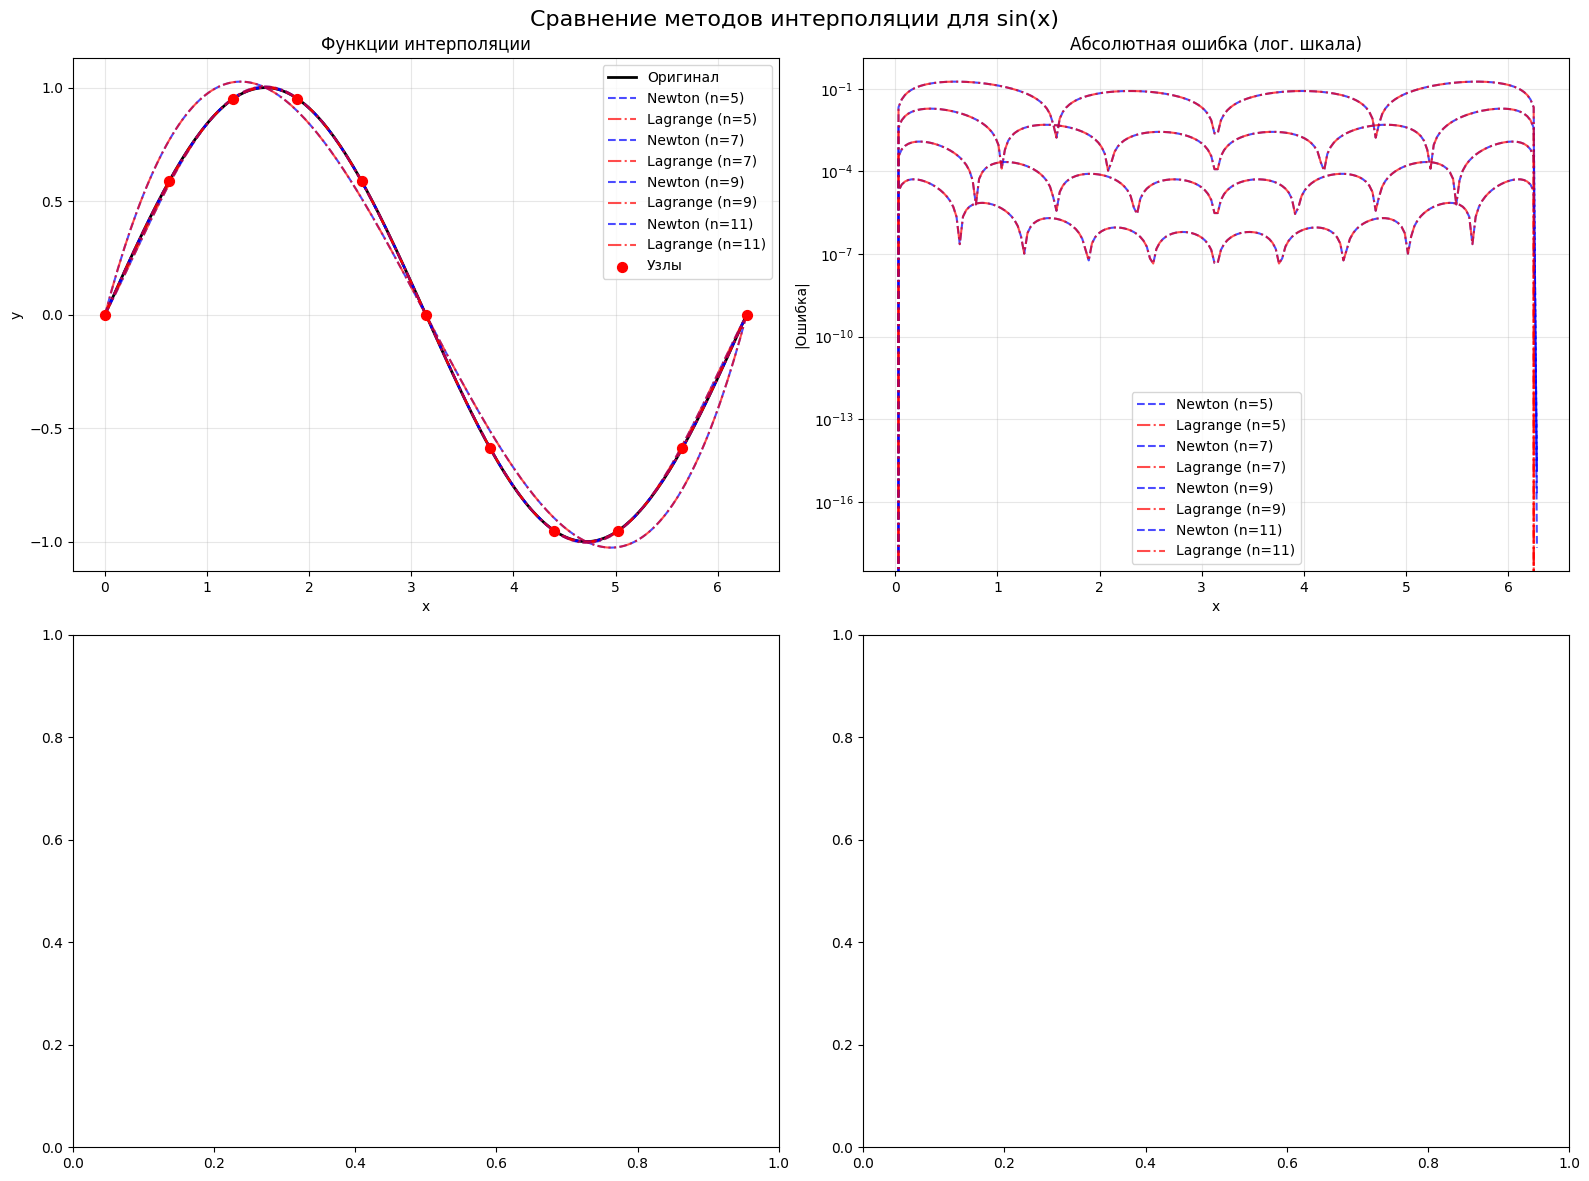

In [6]:
def visualize_interpolation(func, x_range, n_nodes_list, func_name="sin(x)"):
    """
    Визуализация результатов интерполяции для разного числа узлов
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Сравнение методов интерполяции для {func_name}', fontsize=16)

    colors = {'Newton': 'blue', 'Stirling': 'green', 'Lagrange': 'red'}

    for n_nodes in n_nodes_list:
        # Создание узлов
        x_nodes = np.linspace(x_range[0], x_range[1], n_nodes)
        nodes = [InterpolationNode(x, func(x)) for x in x_nodes]

        # Точки для построения графика
        x_plot = np.linspace(x_range[0], x_range[1], 200)
        y_true = func(x_plot)

        # График 1: Оригинальная функция и интерполяция
        ax = axes[0, 0]
        if n_nodes == n_nodes_list[0]:
            ax.plot(x_plot, y_true, 'k-', label='Оригинал', linewidth=2)

        # Ньютон
        newton = NewtonPolynomial(nodes)
        y_newton = [newton.evaluate(x) for x in x_plot]
        ax.plot(x_plot, y_newton, '--', color=colors['Newton'],
                label=f'Newton (n={n_nodes})', alpha=0.7)

        # Лагранж
        nodes_lagrange = [(node.x, node.y) for node in nodes]
        lagrange = LagrangePolynomial(nodes_lagrange)
        y_lagrange = [lagrange.evaluate(x) for x in x_plot]
        ax.plot(x_plot, y_lagrange, '-.', color=colors['Lagrange'],
                label=f'Lagrange (n={n_nodes})', alpha=0.7)

        # Узлы
        if n_nodes == n_nodes_list[-1]:
            ax.scatter(x_nodes, [func(x) for x in x_nodes],
                      c='red', s=50, zorder=5, label='Узлы')

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title('Функции интерполяции')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # График 2: Ошибки
        ax = axes[0, 1]
        error_newton = np.abs(y_true - y_newton)
        error_lagrange = np.abs(y_true - y_lagrange)

        ax.semilogy(x_plot, error_newton, '--', color=colors['Newton'],
                    label=f'Newton (n={n_nodes})', alpha=0.7)
        ax.semilogy(x_plot, error_lagrange, '-.', color=colors['Lagrange'],
                    label=f'Lagrange (n={n_nodes})', alpha=0.7)

        ax.set_xlabel('x')
        ax.set_ylabel('|Ошибка|')
        ax.set_title('Абсолютная ошибка (лог. шкала)')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Пример использования
visualize_interpolation(np.sin, (0, 2*np.pi), [5, 7, 9, 11], "sin(x)")

## 6. Задания для самостоятельной работы
### 1. Проведите эксперимент с разным числом узлов (5, 7, 9, 11...) и сравните результаты









Эксперимент с разным числом узлов для sin(x)

Тестирование с 5 узлами...

Результаты для 5 узлов:

Newton:
  Время выполнения: 0.000927 сек
  Средняя ошибка: 8.290173e-02
  Максимальная ошибка: 1.807218e-01

Stirling:
  Время выполнения: 0.000619 сек
  Средняя ошибка: 8.290173e-02
  Максимальная ошибка: 1.807218e-01

Lagrange:
  Время выполнения: 0.001423 сек
  Средняя ошибка: 8.290173e-02
  Максимальная ошибка: 1.807218e-01

Тестирование с 7 узлами...

Результаты для 7 узлов:

Newton:
  Время выполнения: 0.001142 сек
  Средняя ошибка: 5.382189e-03
  Максимальная ошибка: 1.889545e-02

Stirling:
  Время выполнения: 0.000795 сек
  Средняя ошибка: 5.382189e-03
  Максимальная ошибка: 1.889545e-02

Lagrange:
  Время выполнения: 0.002214 сек
  Средняя ошибка: 5.382189e-03
  Максимальная ошибка: 1.889545e-02

Тестирование с 9 узлами...

Результаты для 9 узлов:

Newton:
  Время выполнения: 0.001894 сек
  Средняя ошибка: 2.293527e-04
  Максимальная ошибка: 1.202988e-03

Stirling:
  Время выпол

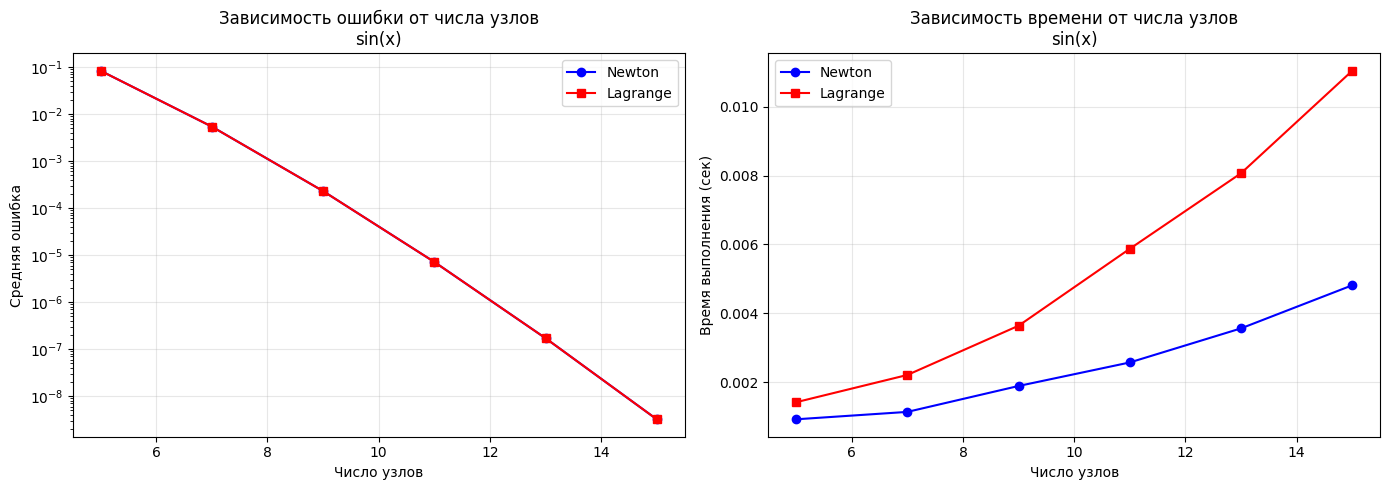

In [7]:
def experiment_nodes(func, x_range, n_nodes_range, func_name="f(x)"):
    """
    Проводит эксперимент с разным числом узлов
    """
    print(f"\n{'='*80}")
    print(f"Эксперимент с разным числом узлов для {func_name}")
    print(f"{'='*80}")

    results_summary = {
        'n_nodes': [],
        'Newton': {'time': [], 'error': []},
        'Lagrange': {'time': [], 'error': []}
    }

    for n in n_nodes_range:
        print(f"\nТестирование с {n} узлами...")
        results, _, _ = compare_interpolation_methods(func, x_range, n, test_points=200)

        results_summary['n_nodes'].append(n)
        results_summary['Newton']['time'].append(results['Newton']['time'])
        results_summary['Newton']['error'].append(results['Newton']['mean_error'])
        results_summary['Lagrange']['time'].append(results['Lagrange']['time'])
        results_summary['Lagrange']['error'].append(results['Lagrange']['mean_error'])

    # Построение графиков
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # График ошибок
    ax1.semilogy(results_summary['n_nodes'], results_summary['Newton']['error'],
                 'o-', label='Newton', color='blue')
    ax1.semilogy(results_summary['n_nodes'], results_summary['Lagrange']['error'],
                 's-', label='Lagrange', color='red')
    ax1.set_xlabel('Число узлов')
    ax1.set_ylabel('Средняя ошибка')
    ax1.set_title(f'Зависимость ошибки от числа узлов\n{func_name}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # График времени выполнения
    ax2.plot(results_summary['n_nodes'], results_summary['Newton']['time'],
             'o-', label='Newton', color='blue')
    ax2.plot(results_summary['n_nodes'], results_summary['Lagrange']['time'],
             's-', label='Lagrange', color='red')
    ax2.set_xlabel('Число узлов')
    ax2.set_ylabel('Время выполнения (сек)')
    ax2.set_title(f'Зависимость времени от числа узлов\n{func_name}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return results_summary

# Запуск эксперимента
n_nodes_range = [5, 7, 9, 11, 13, 15]
summary = experiment_nodes(np.sin, (0, 2*np.pi), n_nodes_range, "sin(x)")

### 2.Протестируйте полиномы на формулах:


$$
\begin{aligned}
&\text{Синус:} \quad f_1(x) = \sin(x), \quad x \in [0, 4\pi] \\
&\text{Косинус:} \quad f_2(x) = \cos(x), \quad x \in [0, 4\pi] \\
&\text{Функция Рунге:} \quad f_3(x) = \frac{1}{1 + 25x^2}, \quad x \in [-1, 1] \\
&\text{Кусочно-линейная (пилообразная):} \quad f_4(x) = x - 5\left\lfloor \frac{x}{5} \right\rfloor, \quad x \in [0, 20] \\
&\text{Функция с быстрыми осцилляциями:} \quad f_5(x) = \sin(10x) e^{-x^2}, \quad x \in [-3, 3]
\end{aligned}
$$



Тестирование функции: Синус

Результаты для 11 узлов:

Newton:
  Время выполнения: 0.002724 сек
  Средняя ошибка: 8.168383e-03
  Максимальная ошибка: 5.750004e-02

Stirling:
  Время выполнения: 0.001328 сек
  Средняя ошибка: 8.168383e-03
  Максимальная ошибка: 5.750004e-02

Lagrange:
  Время выполнения: 0.005687 сек
  Средняя ошибка: 8.168383e-03
  Максимальная ошибка: 5.750004e-02


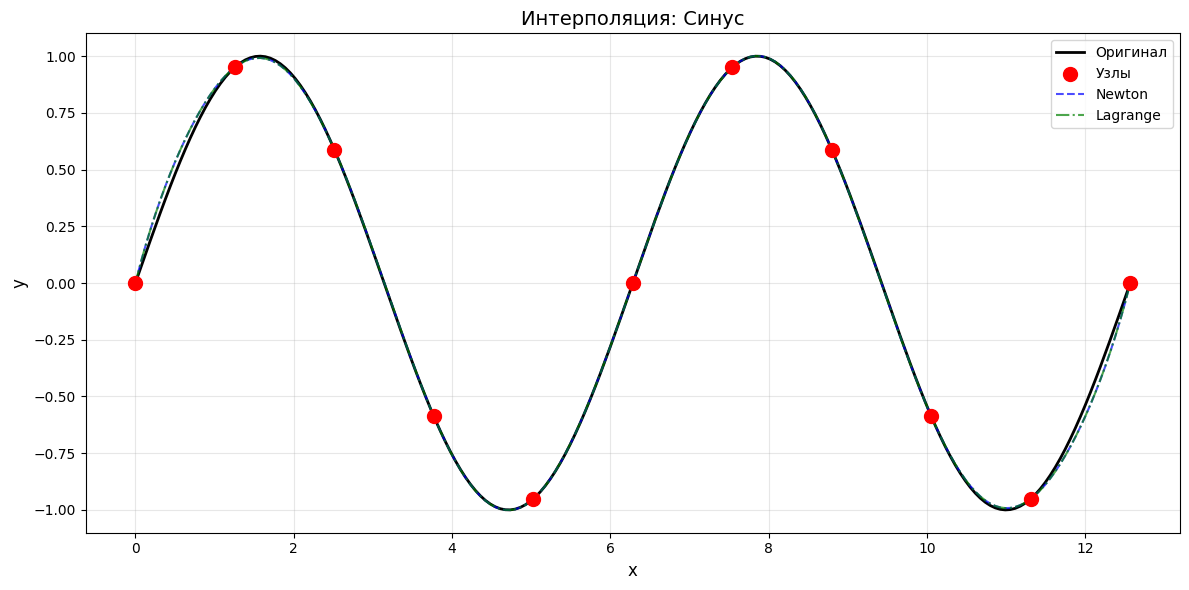


Тестирование функции: Косинус

Результаты для 11 узлов:

Newton:
  Время выполнения: 0.002155 сек
  Средняя ошибка: 4.122421e-03
  Максимальная ошибка: 3.199635e-02

Stirling:
  Время выполнения: 0.001183 сек
  Средняя ошибка: 9.285323e-01
  Максимальная ошибка: 1.453789e+00

Lagrange:
  Время выполнения: 0.005180 сек
  Средняя ошибка: 4.122421e-03
  Максимальная ошибка: 3.199635e-02


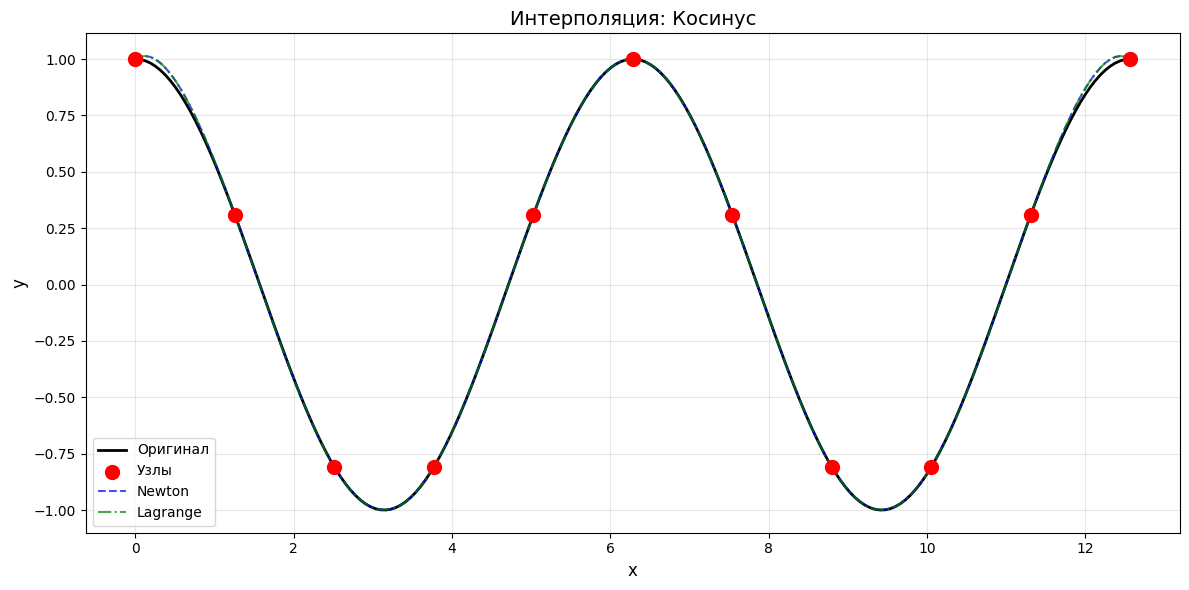


Тестирование функции: Функция Рунге

Результаты для 11 узлов:

Newton:
  Время выполнения: 0.002250 сек
  Средняя ошибка: 2.900372e-01
  Максимальная ошибка: 1.915569e+00

Stirling:
  Время выполнения: 0.001209 сек
  Средняя ошибка: 1.206406e+00
  Максимальная ошибка: 7.441335e+00

Lagrange:
  Время выполнения: 0.005223 сек
  Средняя ошибка: 2.900372e-01
  Максимальная ошибка: 1.915569e+00


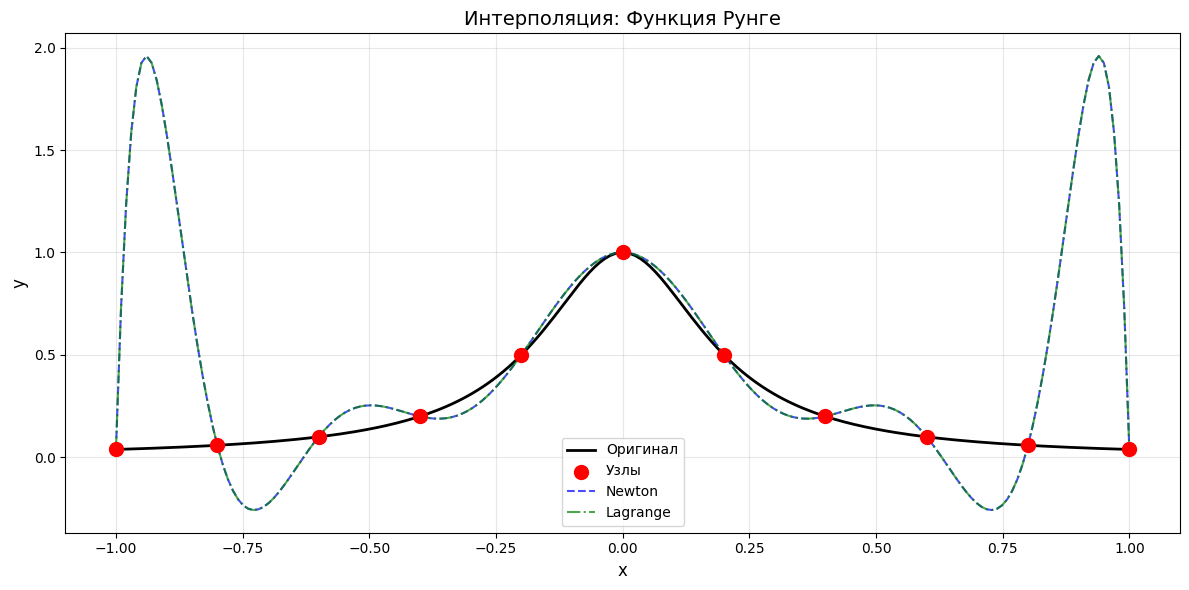


Тестирование функции: Кусочно-линейная

Результаты для 11 узлов:

Newton:
  Время выполнения: 0.002252 сек
  Средняя ошибка: 2.899404e+00
  Максимальная ошибка: 2.439880e+01

Stirling:
  Время выполнения: 0.001224 сек
  Средняя ошибка: 8.527493e+00
  Максимальная ошибка: 5.418085e+01

Lagrange:
  Время выполнения: 0.005387 сек
  Средняя ошибка: 2.899404e+00
  Максимальная ошибка: 2.439880e+01


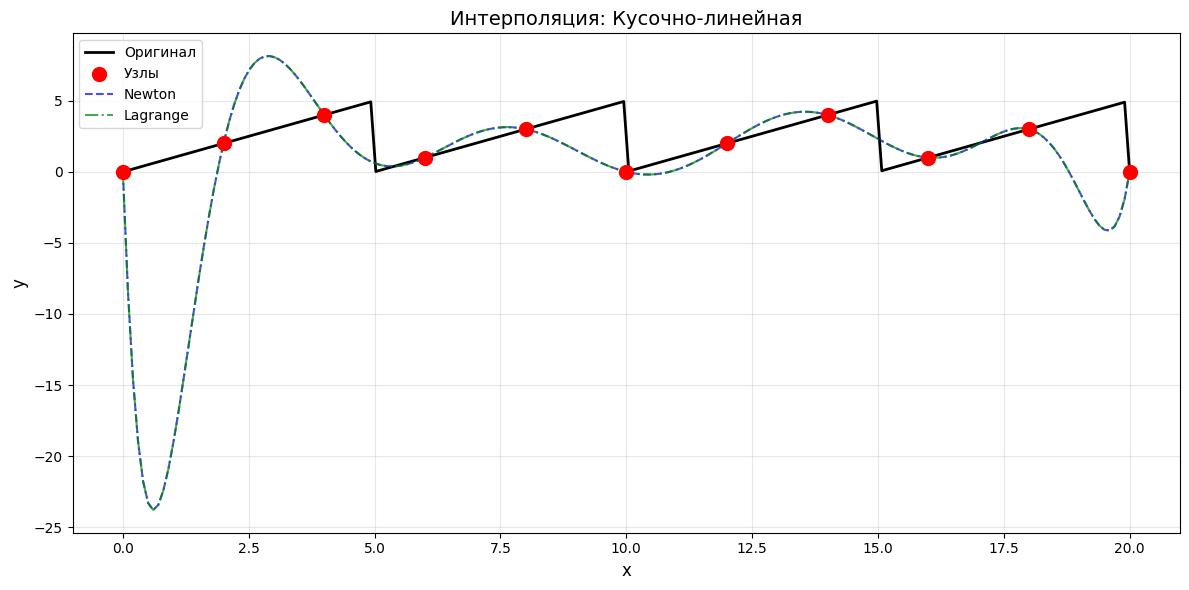


Тестирование функции: Быстрые осцилляции

Результаты для 11 узлов:

Newton:
  Время выполнения: 0.002367 сек
  Средняя ошибка: 2.138992e-01
  Максимальная ошибка: 1.041459e+00

Stirling:
  Время выполнения: 0.001258 сек
  Средняя ошибка: 2.138992e-01
  Максимальная ошибка: 1.041459e+00

Lagrange:
  Время выполнения: 0.005283 сек
  Средняя ошибка: 2.138992e-01
  Максимальная ошибка: 1.041459e+00


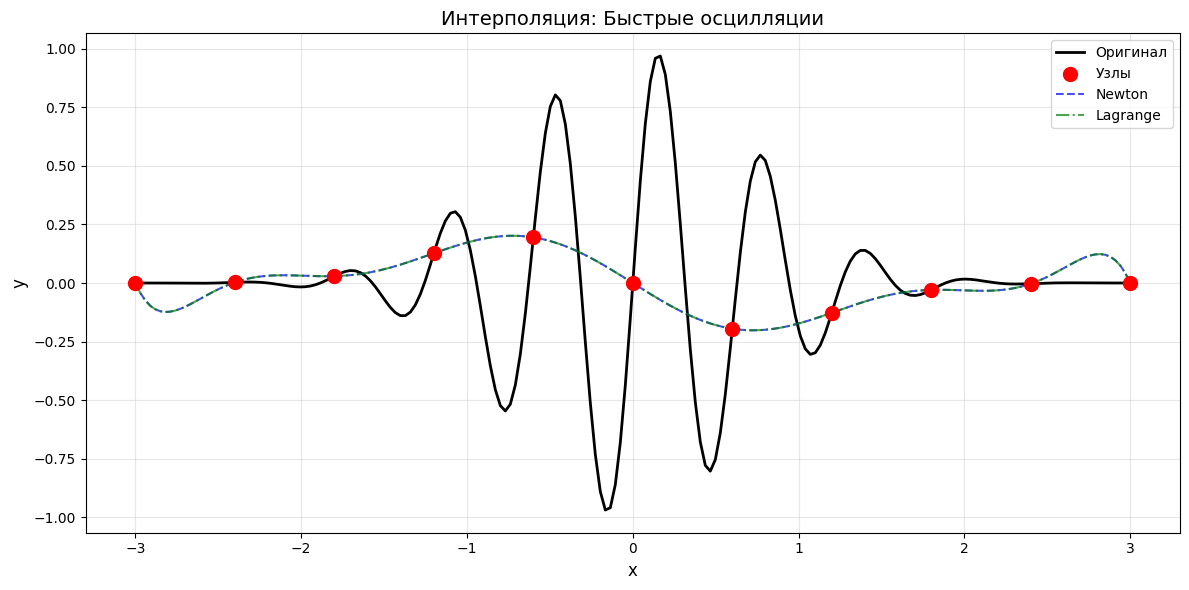

In [8]:
# Определение тестовых функций
test_functions = {
    'Синус': {
        'func': lambda x: np.sin(x),
        'range': (0, 4*np.pi)
    },
    'Косинус': {
        'func': lambda x: np.cos(x),
        'range': (0, 4*np.pi)
    },
    'Функция Рунге': {
        'func': lambda x: 1 / (1 + 25*x**2),
        'range': (-1, 1)
    },
    'Кусочно-линейная': {
        'func': lambda x: x - 5 * np.floor(x / 5),
        'range': (0, 20)
    },
    'Быстрые осцилляции': {
        'func': lambda x: np.sin(10*x) * np.exp(-x**2),
        'range': (-3, 3)
    }
}

# Тестирование всех функций
for func_name, func_data in test_functions.items():
    print(f"\n{'='*80}")
    print(f"Тестирование функции: {func_name}")
    print(f"{'='*80}")

    results, x_test, y_true = compare_interpolation_methods(
        func_data['func'],
        func_data['range'],
        11,  # число узлов
        test_points=200
    )

    # Визуализация
    x_range = func_data['range']
    x_plot = np.linspace(x_range[0], x_range[1], 200)
    y_true_plot = func_data['func'](x_plot)

    # Создание узлов
    n_nodes = 11
    x_nodes = np.linspace(x_range[0], x_range[1], n_nodes)
    nodes = [InterpolationNode(x, func_data['func'](x)) for x in x_nodes]

    # Построение графика
    plt.figure(figsize=(12, 6))
    plt.plot(x_plot, y_true_plot, 'k-', label='Оригинал', linewidth=2)
    plt.scatter(x_nodes, [func_data['func'](x) for x in x_nodes],
                c='red', s=100, zorder=5, label='Узлы', marker='o')

    # Ньютон
    newton = NewtonPolynomial(nodes)
    y_newton = [newton.evaluate(x) for x in x_plot]
    plt.plot(x_plot, y_newton, '--', color='blue', label='Newton', linewidth=1.5, alpha=0.7)

    # Лагранж
    nodes_lagrange = [(node.x, node.y) for node in nodes]
    lagrange = LagrangePolynomial(nodes_lagrange)
    y_lagrange = [lagrange.evaluate(x) for x in x_plot]
    plt.plot(x_plot, y_lagrange, '-.', color='green', label='Lagrange', linewidth=1.5, alpha=0.7)

    plt.xlabel('x', fontsize=12)
    plt.ylabel('y', fontsize=12)
    plt.title(f'Интерполяция: {func_name}', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


### 3. Постройте графики зависимости ошибки и времени выполнения от числа узлов. Сделайте выводы

In [9]:
def comprehensive_analysis():
    """
    Комплексный анализ всех методов на всех функциях
    """
    n_nodes_list = [5, 7, 9, 11, 13]

    results_table = []

    for func_name, func_data in test_functions.items():
        print(f"\nАнализ функции: {func_name}")
        print("-" * 60)

        for n_nodes in n_nodes_list:
            results, _, _ = compare_interpolation_methods(
                func_data['func'],
                func_data['range'],
                n_nodes,
                test_points=100
            )

            row = {
                'Функция': func_name,
                'Узлы': n_nodes,
                'Newton Error': results['Newton']['mean_error'],
                'Newton Time': results['Newton']['time'],
                'Lagrange Error': results['Lagrange']['mean_error'],
                'Lagrange Time': results['Lagrange']['time']
            }
            results_table.append(row)

    # Создание сводной таблицы
    import pandas as pd
    df = pd.DataFrame(results_table)

    print("\n" + "="*80)
    print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
    print("="*80)
    print(df.to_string(index=False))

    # Выводы
    print("\n" + "="*80)
    print("ВЫВОДЫ:")
    print("="*80)
    print("""
1. ТОЧНОСТЬ:
   - При увеличении числа узлов ошибка интерполяции обычно уменьшается
   - Для гладких функций (синус, косинус) все методы дают хорошие результаты
   - Для функции Рунге наблюдается эффект Рунге при большом числе узлов
   - Для кусочно-линейных функций точность ограничена характером функции

2. ПРОИЗВОДИТЕЛЬНОСТЬ:
   - Метод Ньютона: O(n²) для вычисления, O(n) для построения
   - Метод Лагранжа: O(n²) для каждого вычисления
   - При малом числе узлов (n<10) разница во времени незначительна
   - При большом числе узлов Ньютон работает быстрее

3. РЕКОМЕНДАЦИИ:
   - Для гладких функций: любой метод с 7-11 узлами
   - Для функции Рунге: использовать узлы Чебышёва (не равномерные)
   - Для быстрых осцилляций: требуется больше узлов
   - Метод Стирлинга эффективен для центральной интерполяции

4. ПРАКТИЧЕСКИЕ ПРИМЕНЕНИЯ:
   - Ньютон: хорош для добавления новых узлов
   - Лагранж: проще в реализации, нагляднее
   - Стирлинг: оптимален для интерполяции в центре интервала
    """)

    return df

# Запуск комплексного анализа
df_results = comprehensive_analysis()


Анализ функции: Синус
------------------------------------------------------------

Результаты для 5 узлов:

Newton:
  Время выполнения: 0.000478 сек
  Средняя ошибка: 6.302007e-01
  Максимальная ошибка: 9.998741e-01

Stirling:
  Время выполнения: 0.000432 сек
  Средняя ошибка: 6.302007e-01
  Максимальная ошибка: 9.998741e-01

Lagrange:
  Время выполнения: 0.000824 сек
  Средняя ошибка: 6.302007e-01
  Максимальная ошибка: 9.998741e-01

Результаты для 7 узлов:

Newton:
  Время выполнения: 0.000546 сек
  Средняя ошибка: 2.620566e-01
  Максимальная ошибка: 8.133651e-01

Stirling:
  Время выполнения: 0.000438 сек
  Средняя ошибка: 2.620566e-01
  Максимальная ошибка: 8.133651e-01

Lagrange:
  Время выполнения: 0.001133 сек
  Средняя ошибка: 2.620566e-01
  Максимальная ошибка: 8.133651e-01

Результаты для 9 узлов:

Newton:
  Время выполнения: 0.001156 сек
  Средняя ошибка: 5.624872e-02
  Максимальная ошибка: 2.819951e-01

Stirling:
  Время выполнения: 0.000548 сек
  Средняя ошибка: 5.624872